<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/GoodBooks_10K_40D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "How's that book?" -  Neural collaborative filtering with FastAI

*Build a state-of-the-art book recommendation system with just 10 lines of code*

<img src="http://i.imgur.com/uKyBvijg.png"/>

Recommender systems are at the core of pretty much every online service we interact with. Social networking sites like Facebook, Twitter and Instagram recommend posts you might like, or people you might know. Video streaming services like YouTube and Netflix recommend videos, movies or TV shows you might like. Online shopping sites like Amazon recommend products you might want to buy. 

**Collaborative** filtering is perhaps the most common technique used by recommender systems.

> *Collaborative filtering is a method of making predictions about the interests of a user by collecting preferences from many users. The underlying assumption is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.* - [Wikipedia](https://medium.com/r/?url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FCollaborative_filtering)

The [librec](https://medium.com/r/?url=https%3A%2F%2Fwww.librec.net%2F) Java library provides [over 70 different algorithms](https://medium.com/r/?url=https%3A%2F%2Fwww.librec.net%2Fdokuwiki%2Fdoku.php%3Fid%3DAlgorithmList%23recommender_algorithm_list) for collaborative filtering. In this post however, we'll implement a relatively new technique called *neural collaborative filtering*.

## The MovieLens 1M Dataset

The [GoodBooks 10K Dataset](https://www.kaggle.com/zygmunt/goodbooks-10k) Stable benchmark dataset. 1 million ratings from 53424 users on 10000 books. 






user_id,book_id,rating

1,258,5

2,4081,4

2,260,5

2,9296,5

2,2318,3

Ratings go from one to five. Both book IDs and user IDs are contiguous. For books, they are 1-10000, for users, 1-53424.

Our objective here is to build a *model* that can predict how a user would rate a book they haven't already seen, by looking at the book ratings of other users with similar tastes.

## System Setup

If you want to follow along and run the code as you read, you can clone this notebook, install the required dependencies using [conda](https://conda.io), and start Jupyter by running the following commands on the terminal:

```
pip install jovian --upgrade     # Install the jovian library 
jovian clone 5bc23520933b4cc187cfe18e5dd7e2ed # Download notebook
cd movielens-fastai              # Enter the created directory 
jovian install                   # Install the dependencies
conda activate movielens-fastai  # Activate virtual environment
jupyter notebook                 # Start Jupyter
```

Make sure you have [conda](https://conda.io) installed before running the above commands. You can also click on the **"Run on Binder"** button at the top to start a Jupyter notebook server hosted on mybinder.org  instantly.

## Preparing the Data

You can download the GoodBooks 10K dataset [from this link](https://github.com/zygmuntz/goodbooks-10k). 

Once downloaded, unzip and extract the data into a directory ml-100k next to the Jupyter notebook. As described in the [README](https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847), the file ratings.csv contains the list of ratings.

*On Linux and Mac, you can simply run the follwing cell to download and extract the data:*

In [0]:
# Download and extract the data (only for Linux and Mac)
#!rm -rf goodbooks
#!wget -q https://github.com/zygmuntz/goodbooks-10k/blob/master/ratings.csv


We begin the importing the required modules from Pandas and FastAI.

In [0]:
import pandas as pd
from fastai.collab import CollabDataBunch, collab_learner

We can now read the data from the CSV file `u.data` into a Pandas [data frame](https://medium.com/r/?url=https%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fstable%2Freference%2Fapi%2Fpandas.DataFrame.html), and create a FastAI [data bunch](https://medium.com/r/?url=https%3A%2F%2Fdocs.fast.ai%2Fbasic_data.html%23Get-your-data-ready-for-training) which:

1. Converts the Pandas data frame into tensors
2. It splits the data into a training set and a validation set
3. Creates data loaders to access the data in batches
4. Checks if a GPU is available, and moves the data to the GPU

In [2]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [3]:
data = CollabDataBunch.from_df(ratings_df, valid_pct=0.1)
data.show_batch()

book_id,user_id,target
2759,15930,4.0
8530,29259,4.0
9034,24925,4.0
6243,36972,4.0
6873,51243,2.0


## Neural collaborative filtering model

The model itself is quite simple. We represent each user `u` and each movie `m` by vector of a predefined length `n`. The rating for the movie `m` by the user `u`, as predicted by the model is simply the dot product of the two vectors.

<img src="https://cdn-images-1.medium.com/max/800/1*RuAjbXDwvTAv74NtPS-FbQ.png" style="width:360px"/>

Here's a small subset of the users and movies, represented by randomly chosen vectors of length 5, and the predicted ratings:

<img src="https://cdn-images-1.medium.com/max/1600/1*y9H2v3PsytrCajWSNJJDsA.png" style="width:480px"/>

Since the vectors are chosen randomly, it's quite unlikely that the ratings predicted by the model match the actual ratings. Our objective, while training the model, is to gradually adjust the elements inside the user & movie vectors so that predicted ratings get closer to the actual ratings.

We can use the `collab_learner` method from `fastai` to create a neural collaborative filtering model.

In [0]:
learn = collab_learner(data, n_factors=40, y_range=[0,5.5], wd=.1)


The actual model created here contains 2 important enhancements on the simpler version described earlier:

First, apart from the vectors for users and movies, it also add bias terms to account for outliers, since some users tend to always rate movies very high or very low, and some movies tend to be universally acclaimed or disliked.

<img src="https://cdn-images-1.medium.com/max/800/1*vF7oEwpuKfXP8_CYK_KgdQ.png" style="width:360px" />

Second, it applies the Sigmoid activation function to the above output, and scales it so that the result always lies in the given `y_range`, which is 0 to 5.5 in this case.

<img src="https://cdn-images-1.medium.com/max/800/1*NloTSPs4pCMYDZ8G1kxhoQ.png" style="width:420px"/>

## Training the model

The learner uses the [*mean squared error*](https://en.wikipedia.org/wiki/Mean_squared_error) loss function to evaluate the predictions of the model, and the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) to adjust the parameters (vectors and biases) using gradient descent. Before we train the model, we use the [learning rate finder](https://docs.fast.ai/callbacks.lr_finder.html) to select a good learning for the optimizer.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


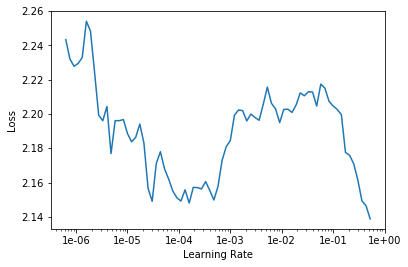

In [8]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

Upon inspection of the graph, we can see that the decrease in loss starts to decrease when the learning rate is around `0.01`. We can choose this as our learning rate, and train for 5 epochs, while annealing the learning rate using the [1-cycle policy](https://sgugger.github.io/the-1cycle-policy.html), which leads to faster convergence.

In [10]:
learn.fit_one_cycle(10, 0.001)

epoch,train_loss,valid_loss,time
0,1.896684,1.894076,02:11
1,1.091229,1.110037,02:13
2,0.908801,0.922708,02:14
3,0.919494,0.898161,02:13
4,0.876140,0.887953,02:13
5,0.860353,0.878859,02:13
6,0.878016,0.870541,02:14
7,0.845412,0.864428,02:14
8,0.820162,0.861246,02:13
9,0.776691,0.860755,02:13


epoch,train_loss,valid_loss,time
0,0.797163,0.860511,02:14
1,0.837796,0.874330,02:15
2,0.851318,0.890505,02:14
3,0.876289,0.887465,02:14
4,0.857890,0.883708,02:14
5,0.848219,0.875414,02:15
6,0.844268,0.869082,02:14
7,0.817047,0.862839,02:14
8,0.797703,0.859919,02:14
9,0.771293,0.859388,02:14


In just 15 seconds, the mean squared error has come down to around 0.82, which is quite close to the state of the art (as compared with [these benchmarks](https://medium.com/r/?url=https%3A%2F%2Fwww.librec.net%2Frelease%2Fv1.3%2Fexample.html)). And it only took us 8 lines of code to load the data and train the model!

## Looking at some predictions

While it's great to see the loss go down, let's look at some actual predictions of the model.

In [11]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[:16]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))

Real	Pred	Difference
3.0	3.2	0.2
4.0	3.8	-0.2
4.0	3.4	-0.6
4.0	3.6	-0.4
3.0	3.5	0.5
5.0	3.2	-1.8
5.0	4.6	-0.4
4.0	3.6	-0.4
4.0	3.6	-0.4
3.0	3.2	0.2
5.0	4.5	-0.5
5.0	4.2	-0.8
3.0	3.2	0.2
5.0	4.0	-1.0
4.0	3.1	-0.9
2.0	3.2	1.2


Indeed, the predictions are quite close to the actual ratings. We can now use this model to predict how users would rate books they haven't read, and recommend books that have a high predicted rating.

<img src="https://cdn.lifehack.org/wp-content/uploads/2014/05/goodreads.jpg" />

In [12]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(10001, 40)
  (i_weight): Embedding(53334, 40)
  (u_bias): Embedding(10001, 1)
  (i_bias): Embedding(53334, 1)
)

In [13]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 400,040    True      
______________________________________________________________________
Embedding            [40]                 2,133,360  True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________
Embedding            [1]                  53,334     True      
______________________________________________________________________

Total params: 2,596,735
Total trainable params: 2,596,735
Total non-trainable params: 0



## Save and commit

As a final step, we can save and commit our work using the `jovian` library.

In [0]:
#!pip install jovian

In [0]:
#import jovian

In [0]:
#jovian.commit()

Jovian uploads the notebook to [jvn.io](https://jvn.io), captures the Python environment and creates a sharable link for the notebook. You can use this link to share your work and let anyone reproduce it easily with the `jovian clone` command. Jovian also includes a powerful commenting interface, so you (and others) can discuss & comment on specific parts of your notebook.

## Further Reading

In a future post, we'll dive deeper and see how `DataBunch` and `collab_learner` are actually implemented, using PyTorch. We'll also explore how we can interpret the vectors and biases learned by the model, and see some interesting results.

In the meantime, following are some resources if you'd like to dive deeper into the topic:

* [Lesson 4](https://course.fast.ai/videos/?lesson=4) of FastAI's "Practical Deep Learning for Coders" course

* [Paper](https://arxiv.org/abs/1708.05031) introducing neural collaborative filtering

* [PyTorch: Zero to GANs](https://medium.com/jovian-io/pytorch-basics-tensors-and-gradients-eb2f6e8a6eee)  - tutorial series covering the basics of PyTorch and neural networks